In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import PIL, cv2, os, imghdr

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
data_dir = 'datasets/flower_photos' 

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [33]:
def generate_image_data(img_x, img_y, data_dir, seed=42):
    '''
    Based of X, y and image location, returns dataset
    '''
    tf.random.set_seed(seed)
    data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_x, img_y))
    data = data.map(lambda x, y: (x/255, y))
    return data

def generate_train_val_test(data, seed=42):
    tf.random.set_seed(seed)
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.1)
    test_size = int(len(data) * 0.2)
    
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size).take(test_size)
    return train, val, test

def apply_augmentation(img_x, img_y, factor, seed=42):
    tf.random.set_seed(seed)
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_x, img_y, 3)),
            layers.experimental.preprocessing.RandomRotation(factor),
            layers.experimental.preprocessing.RandomZoom(factor),
        ]
    )
    return data_augmentation

def lr_scheduler(epoch, lr):
    if epoch < 7:
        return lr
    return lr * tf.math.exp(-0.1)

# Experiment 1 (VGG like model)

In [48]:
img_dim = 128

In [52]:
data = generate_image_data(img_dim, img_dim, data_dir, seed=42)

Found 5179 files belonging to 5 classes.


In [95]:
train, val, test = generate_train_val_test(data, seed=42)

In [54]:
data_augmentation = apply_augmentation(img_dim, img_dim, 0.1, seed=42)

In [55]:
logdir='logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
tf.keras.backend.clear_session()

In [63]:
num_classes = 5
batch_size = 32
epochs = 30
tf.random.set_seed(42)

In [64]:
lr_schedule = LearningRateScheduler(lr_scheduler)

model = Sequential([
    data_augmentation,

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    
    layers.Flatten(),

    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
#     layers.Dense(16, activation='relu'),

    
    layers.Dense(num_classes)
])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_aug = model.fit(train,  epochs=epochs, batch_size = batch_size, validation_data=val,\
                     callbacks=[tensorboard_callback, early_stopping])


Epoch 1/30
113/113 [==============================] - 75s 651ms/step - loss: 1.4131 - accuracy: 0.3825 - val_loss: 1.2197 - val_accuracy: 0.4629
Epoch 2/30
113/113 [==============================] - 73s 648ms/step - loss: 1.2142 - accuracy: 0.5086 - val_loss: 1.0250 - val_accuracy: 0.6230
Epoch 3/30
113/113 [==============================] - 73s 644ms/step - loss: 1.0896 - accuracy: 0.5929 - val_loss: 0.8945 - val_accuracy: 0.6602
Epoch 4/30
113/113 [==============================] - 73s 646ms/step - loss: 0.9883 - accuracy: 0.6264 - val_loss: 0.7870 - val_accuracy: 0.7090
Epoch 5/30
113/113 [==============================] - 73s 643ms/step - loss: 0.9160 - accuracy: 0.6634 - val_loss: 0.7815 - val_accuracy: 0.6895
Epoch 6/30
113/113 [==============================] - 72s 638ms/step - loss: 0.8505 - accuracy: 0.6889 - val_loss: 0.7267 - val_accuracy: 0.7266
Epoch 7/30
113/113 [==============================] - 73s 648ms/step - loss: 0.7827 - accuracy: 0.7273 - val_loss: 0.6763 - val_ac

In [67]:
model.evaluate(test)

32/32 [==============================] - 8s 150ms/step - loss: 0.7033 - accuracy: 0.7500


[0.7033061385154724, 0.75]

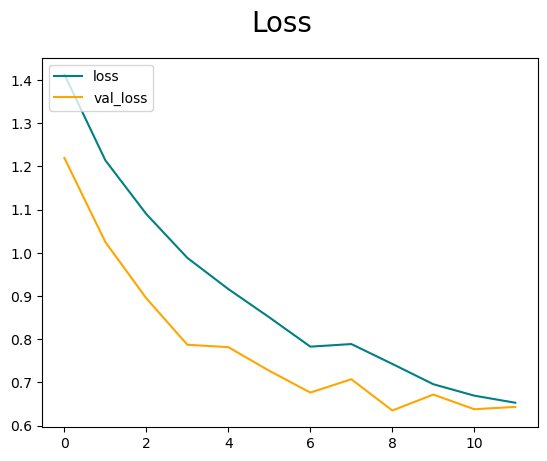

In [68]:
fig = plt.figure()
plt.plot(hist_aug.history['loss'], color='teal', label='loss')
plt.plot(hist_aug.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

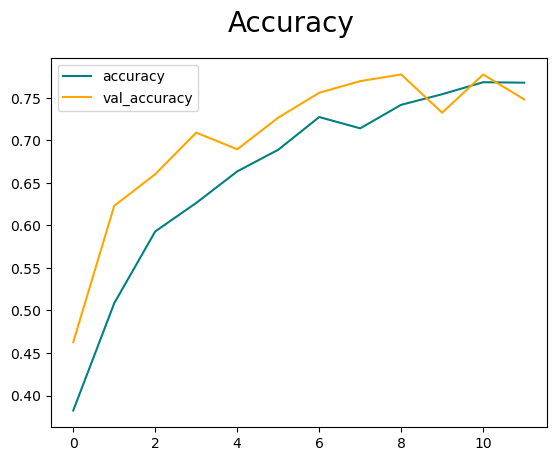

In [69]:
fig = plt.figure()
plt.plot(hist_aug.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_aug.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [70]:
model.save('saved_models/model_aug.keras')

In [ ]:
model.weights

In [91]:
loaded_model = load_model('saved_models/model_aug.keras')

In [92]:
from tensorflow.keras.applications.vgg16 import preprocess_input
image_path = './test_images/rose_1.jpeg'   
image = cv2.imread(image_path)
resized_image = cv2.resize(image, (128, 128))
resized_image = np.expand_dims(resized_image, axis=0)


In [93]:
preprocessed_image = preprocess_input(resized_image)
predictions = loaded_model.predict(preprocessed_image)

1/1 [==============================] - 0s 88ms/step


In [94]:

np.argmax(predictions)

2

In [97]:

class_names = [str(i) for i in range(5)]  
num_classes = len(class_names)

precision_metrics = [Precision() for _ in range(num_classes)]
recall_metrics = [Recall() for _ in range(num_classes)]

for batch in data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    for i in range(num_classes):
        class_label = i
        class_true = tf.cast(tf.equal(y, class_label), tf.float32)
        class_pred = tf.cast(tf.equal(tf.argmax(yhat, axis=1), class_label), tf.float32)

        precision_metrics[i].update_state(class_true, class_pred)
        recall_metrics[i].update_state(class_true, class_pred)

precision_results = [precision_metric.result().numpy() for precision_metric in precision_metrics]
recall_results = [recall_metric.result().numpy() for recall_metric in recall_metrics]

# Calculate F1 score for each class
f1_results = [2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
              for precision, recall in zip(precision_results, recall_results)]

print("Precision for each class:", precision_results)
print("Recall for each class:", recall_results)
print("F1 score for each class:", f1_results)

1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 137ms/step
Precision for each class: [0.7869416, 0.74600357, 0.80156076, 0.77, 0.823638]
Recall for each class: [0.66505325, 0.76502734, 0.70490193, 0.9112426, 0.8796844]
F1 score for each class: [0.7208813866683481, 0.7553956681287586, 0.7501304291917663, 0.8346883013425596, 0.8507390976690072]


# Experiment 2 Resnet like

In [ ]:
img_size = 128
data = generate_image_data(img_size, img_size, data_dir)
train, val, test = generate_train_val_test(data)
data_augmentation = apply_augmentation(img_size, img_size, 0.1)
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [160]:
tf.keras.backend.clear_session()

num_classes = 5
batch_size=16
epochs=7

In [161]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch):
    # Your learning rate schedule logic here
    # For example, you can decay the learning rate by a factor every few epochs
    initial_learning_rate = 0.0001
    decay_factor = 0.1
    decay_epochs = 10
    return initial_learning_rate * decay_factor ** (epoch // decay_epochs)

def build_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Initial Convolution
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 32)
    x = layers.Dropout(0.5)(x)  
    x = residual_block(x, 32)
    x = layers.Dropout(0.5)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Additional Dense Layer
    x = layers.Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Fully Connected Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

resnet_model = build_resnet((img_size, img_size, 3), num_classes)

NameError: name 'Dropout' is not defined

In [162]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['sequential[20][0]']         
                                                                                                  
 re_lu (ReLU)                (None, 64, 64, 32)           0         ['conv2d[0][0]']              
                                                                                              

In [ ]:
# Compile the model with learning rate schedule
optimizer = tf.keras.optimizers.Adam()
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_callback = LearningRateScheduler(lr_scheduler)

restnet_hist = resnet_model.fit(train, validation_data=val, epochs=epochs, callbacks=[lr_callback])

Epoch 1/7


In [106]:
resnet_model.evaluate(test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
fig = plt.figure()
plt.plot(restnet_hist.history['loss'], color='teal', label='loss')
plt.plot(restnet_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(restnet_hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(restnet_hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()